# Finds optical events in a video file

### Imports

In [1]:
# Python standard library
import sys
import os

# Scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Program specific
PORE_STATS_BASE_DIRECTORY = os.getcwd().replace('notebooks', '')
sys.path.append(PORE_STATS_BASE_DIRECTORY + '/pore_stats/oi/')
import optical_imaging as oi
import oi_file

### Load data

In [2]:
# Define file path
data_base_path = '/home/prestonh/Desktop/Research/cancer_cells/data'
date = '/3-3-2017'
particle_type = '/HCT-116'
channel_type = '/17p5_30_17p5'
file_index = '5'
file_path = data_base_path + date + particle_type + channel_type + '/oi/bin/test_camera_' + file_index

# Set output file path
output_file_path = file_path + '_events.json'

# Open video
oi_vid = oi_file.Raw(file_path, 512, 288, 50000, 5)

### Find a frame that has a cluster

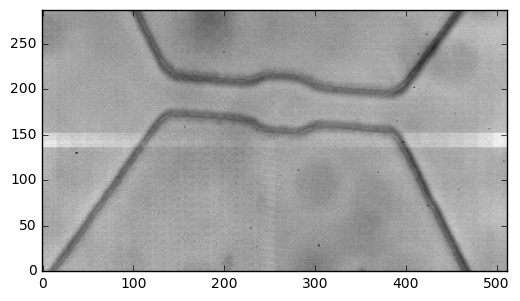

In [3]:
template_index = 0
template_frame = oi_vid.get_frame(template_index)
plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

In [4]:
threshold_difference = 0.02

num_found = 0
for i in range(0, oi_vid._total_frames):
    if i%1000 == 0:
        print i
    frame = oi_vid.get_frame(i)
    clusters = oi.find_clusters_percentage_based(frame, template_frame, threshold_difference = threshold_difference)
    if(len(clusters)) > 0:
        print i
        num_found+=1
        if num_found > 5:
            #break
            pass
            

0
1000
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331


KeyboardInterrupt: 

### Show image, template image, difference

1


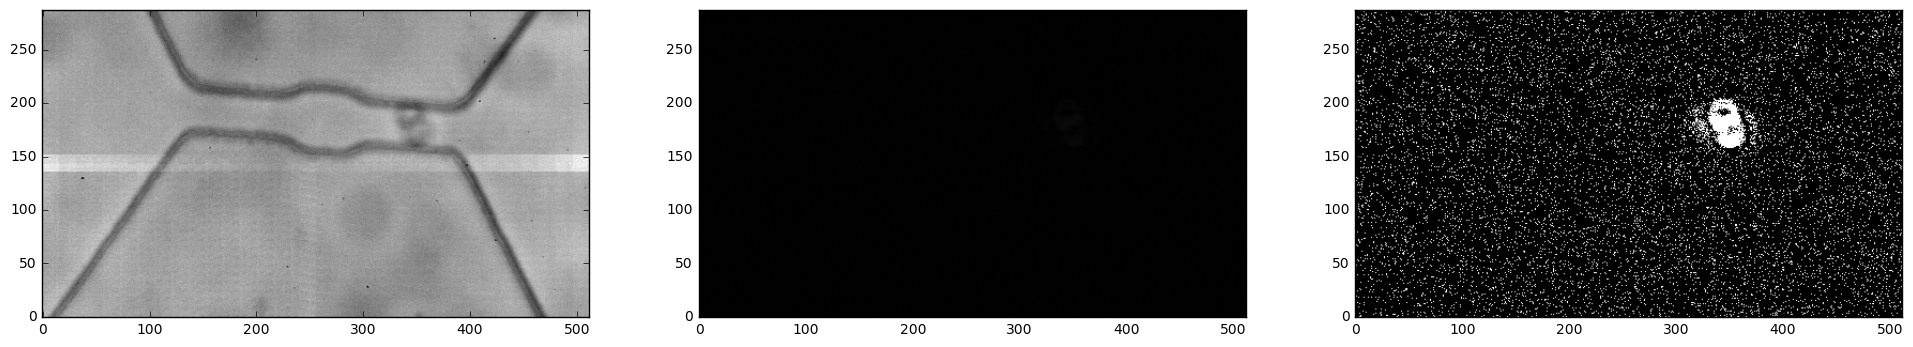

In [10]:
index = 1320

template_frame = oi_vid.get_frame(template_index)
frame = oi_vid.get_frame(index)

threshold_difference = .01#.035
alpha = 1#2



beta = 'avg'    # -(np.mean(frame)-.5)
#template_frame = oi.change_frame_contrast(template_frame, alpha = alpha, beta = beta)
#frame = oi.change_frame_contrast(frame, alpha = alpha, beta = beta)


cluster_threshold = 200


neg_frame = abs(frame - template_frame)
clusters = oi.find_clusters_percentage_based(frame, template_frame, threshold_difference = threshold_difference,\
                                             cluster_threshold = cluster_threshold)
temp_neg_frame = np.copy(neg_frame)
temp_neg_frame[temp_neg_frame > threshold_difference] = 1
temp_neg_frame[temp_neg_frame <= threshold_difference] = 0

print len(clusters)
fig, axes = plt.subplots(1,3,figsize=(24,8))

# Raw image
plt.sca(axes[0])
plt.imshow(frame, cmap = 'gray', origin = 'lower')

# Negative
plt.sca(axes[1])
plt.imshow(neg_frame, cmap = 'gray', vmin = 0, vmax = 1, origin = 'lower')

# Thresholded negative
plt.sca(axes[2])
plt.imshow(temp_neg_frame, vmin = 0, vmax = 1, cmap = 'gray', origin = 'lower')

plt.show()

### Find events

In [ ]:
reload(oi)
alpha = 1
beta = 'avg'
raw_events = oi.find_events(oi_vid, ti = 0, template_frame = oi_vid.get_frame(template_index), threshold_difference = threshold_difference, cluster_threshold = cluster_threshold, alpha = alpha, beta = 'avg')

t:  0 / 49974 	clusters: 0 	active: 0 	inactive: 0


### Inspect trajectories

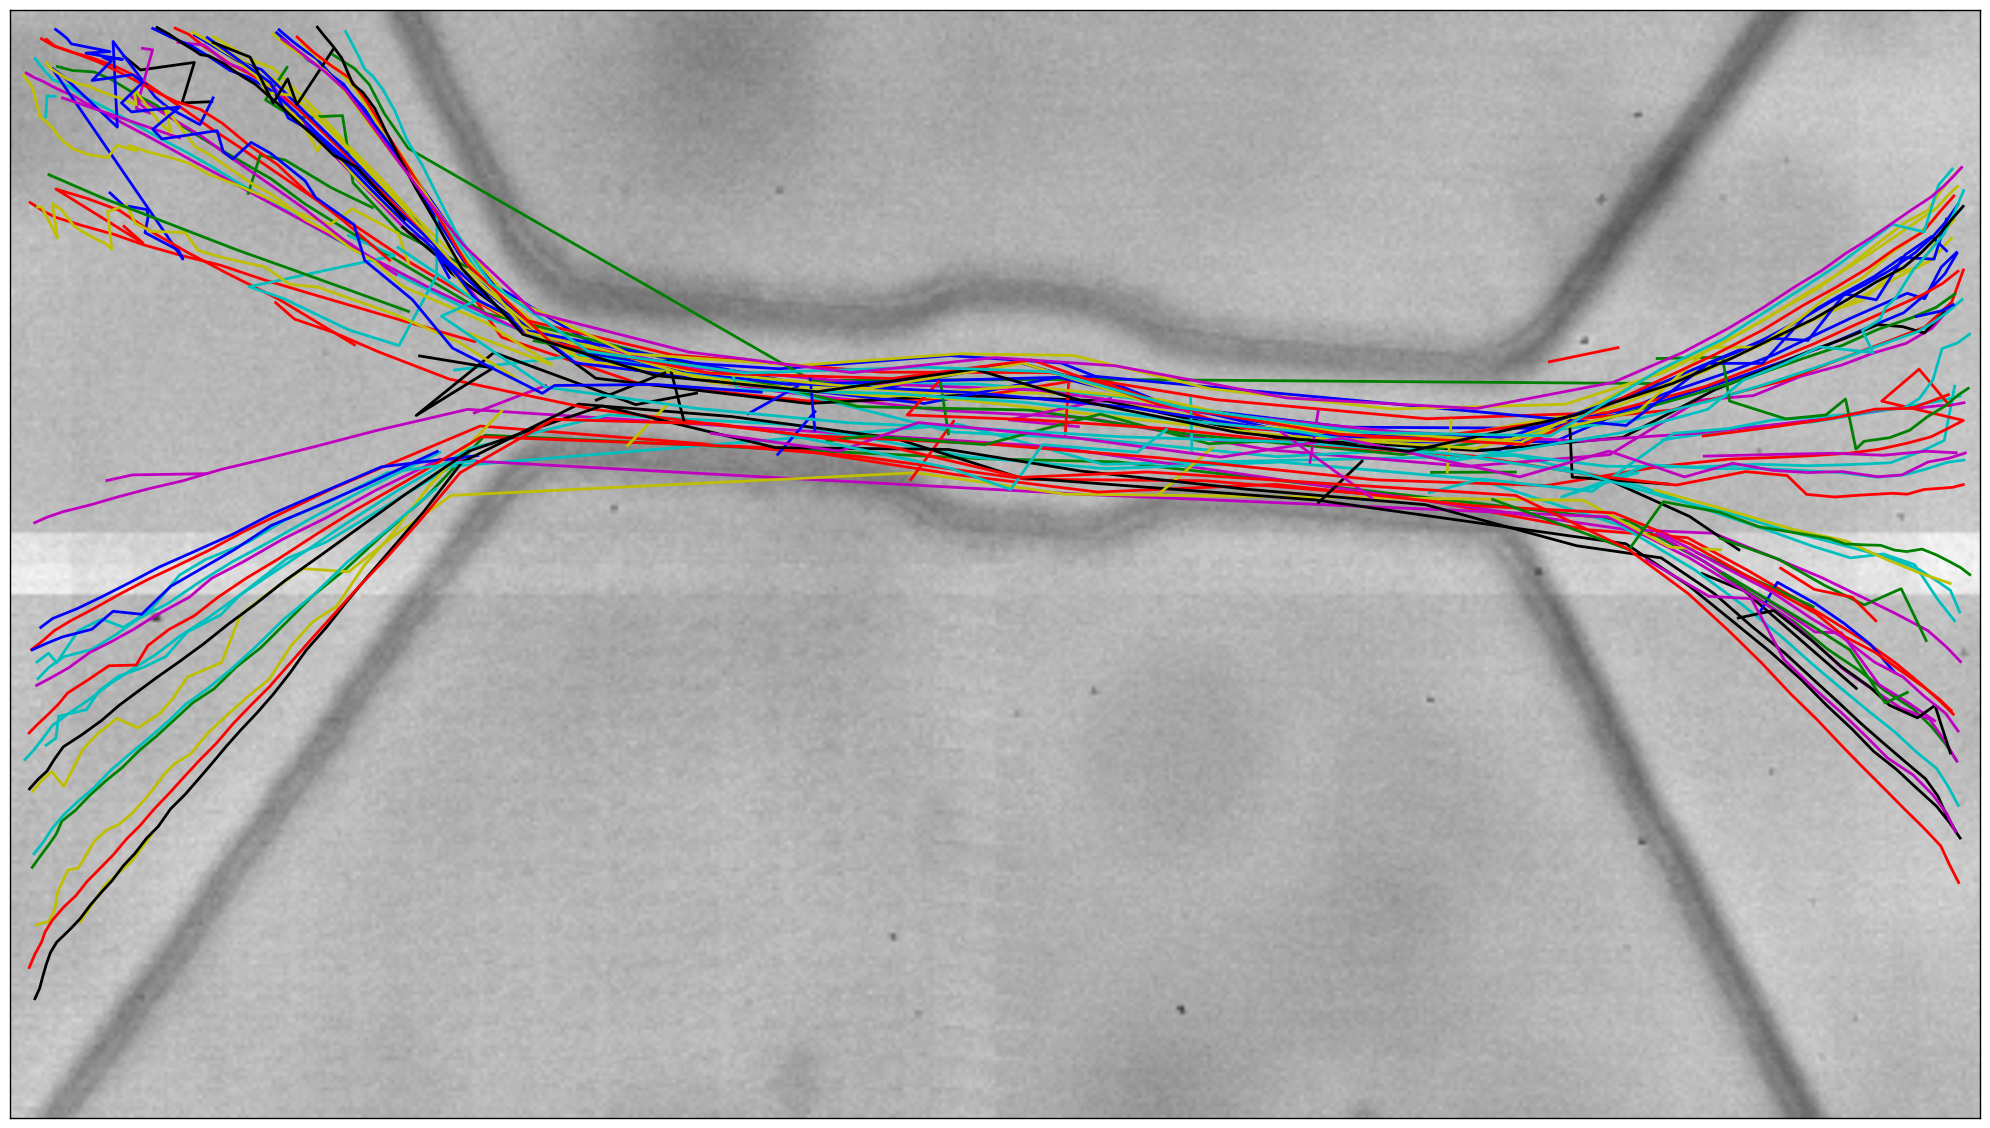

In [7]:
fig = plt.figure(figsize = (20,12))
for i, event in enumerate(raw_events[:]):
    px = []
    py = []
    for detection in event._detections:
        px.append(detection._px)
        py.append(detection._py)
    plt.plot(px, py, lw = 2)

plt.imshow(template_frame, alpha=0.8, cmap = 'gray', origin = 'lower')
plt.xticks([])
plt.yticks([])

fig.tight_layout()


plt.show()

### Save events

In [8]:
print output_file_path

/home/prestonh/Desktop/Research/cancer_cells/data/3-3-2017/HCT-116/17p5_30_17p5/oi/bin/test_camera_5_events.json


In [9]:
oi_file.save_oi_events_json(output_file_path, raw_events)